In [1]:
import numpy as np
from mxnet import nd
classes = ['background','p1','p2','p3','p4',
           'p5','p6','p7','p8','p9','p10',
           'p11','p12','p13','p14','p15',
           'p16','p17','p18','p19']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,64,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0]]

# len(classes), len(colormap)



In [2]:
def image_crop(data,label,min_xy,max_xy,width=640,height=640):
#     x0 = int(min_xy[0] - (width - (max_xy[0] - min_xy[0])) / 2)
#     y0 = int(min_xy[1] - (height - (max_xy[1] - min_xy[1])) / 2)
    x0 = 504
    y0 = 697
    expand_size = 55
    cropped_label = nd.zeros((data.shape[0],data.shape[1]))
#     cropped_label[label[1],label[0]] = 1
    cropped_label[label[1]-expand_size:label[1]+expand_size,label[0]-expand_size:label[0]+expand_size] = 1
    return image.fixed_crop(data,x0,y0,width,height), cropped_label[y0:y0+640,x0:x0+640]

In [3]:
from mxnet import image
import sys
sys.path.append('..')
import utils
from time import time

data_root = '../data'
image_root = data_root + '/CephalometricLandmark/RawImage'
txt_root = data_root + '/CephalometricLandmark/AnnotationsByMD'

def read_images(landmark_index,dataset_num=0):
    
    if dataset_num == 0:
        begin_index = 1
        end_index = 151
        image_path = image_root + '/TrainingData'
    elif dataset_num == 1:
        begin_index = 151
        end_index = 301
        image_path = image_root + '/Test1Data'
    else:
        begin_index = 301
        end_index = 401
        image_path = image_root + '/Test2Data'
    
    data , label =  [None] * (end_index - begin_index), [None] * (end_index - begin_index)
#     expand_label =  [None] * (end_index - begin_index)
#     bounding_box = [[[2000,2000],[0,0],[0,0]] for i in range(19)]
    bounding_box = [[2400,2400],[0,0],[0,0]]
    index = 0
    expand_size = 20
    for i in range(begin_index,end_index):
        image_filename = image_path + "/%03d.bmp" % i
        txt_filename1 =  txt_root + '/400_senior' +"/%03d.txt" % i
        txt_filename2 =  txt_root + '/400_junior' +"/%03d.txt" % i
#         label_image[index] = nd.zeros_like(data[index])
        
        
        with open(txt_filename1, 'r') as f:
            txts = f.read().split()
#读取所有的标志点，会导致内存过大，最好一个一个读取
#         for j in range(19):
#             x = int(txts[j].split(',')[0])
#             y = int(txts[j].split(',')[1])
#             label[index][j]=[x,y]
#             label_image[index][y-expand_size:y+expand_size,x-expand_size:x+expand_size] = colormap[j+1]

#             bounding_box[j][0][0] = min(bounding_box[j][0][0],x)
#             bounding_box[j][0][1] = min(bounding_box[j][0][1],y)
#             bounding_box[j][1][0] = max(bounding_box[j][1][0],x)
#             bounding_box[j][1][1] = max(bounding_box[j][1][1],y)
#             bounding_box[j][2][0] = bounding_box[j][1][0] - bounding_box[j][0][0]
#             bounding_box[j][2][1] = bounding_box[j][1][1] - bounding_box[j][0][1]
        x = int(txts[landmark_index].split(',')[0])
        y = int(txts[landmark_index].split(',')[1])
#         label_image[index][y-expand_size:y+expand_size,x-expand_size:x+expand_size] = colormap[landmark_index+1]

        
        bounding_box[0][0] = min(bounding_box[0][0],x)
        bounding_box[0][1] = min(bounding_box[0][1],y)
        bounding_box[1][0] = max(bounding_box[1][0],x)
        bounding_box[1][1] = max(bounding_box[1][1],y)
        bounding_box[2][0] = bounding_box[1][0] - bounding_box[0][0]
        bounding_box[2][1] = bounding_box[1][1] - bounding_box[0][1]
        
        image_tmp = image.imread(image_filename)
        data[index], label[index] = image_crop(image_tmp,[x,y],bounding_box[0],bounding_box[1])
#         print(data[index].shape, label[index].shape)
        del image_tmp
        index+=1
#     return data,label_image,label,bounding_box
    return data,label



# train_images, train_label_images, train_labels,bounding_boxes= read_images(0)


In [4]:
# imgs = [train_images[0],train_label_images[0]]
# # print(bounding_boxes)
# # print(type(train_images))
# landmarkindex = 2
# margin_size = 100
# for i in range(19):
# #     imgs += [train_images[i][900:1100,800:1000],train_labels[i][990:1050,800:860]]
# #     x = train_labels[i][1][0]
# #     y = train_labels[i][1][1]
# #     size = 40
# #     imgs += [train_images[i][y-size:y+size,x-size:x+size],train_label_images[i][y-size:y+size,x-size:x+size]]
    
#     minx = bounding_boxes[0][0]
#     miny = bounding_boxes[0][1]
#     maxx = bounding_boxes[1][0]
#     maxy = bounding_boxes[1][1]

#     imgs += [train_images[i][miny-margin_size:maxy+margin_size,minx-margin_size:maxx+margin_size],train_label_images[i][miny-margin_size:maxy+margin_size,minx-margin_size:maxx+margin_size]]
# # print(train_labels[0][981:1001,819:839])
# utils.show_images(imgs, nrows=19, ncols=2,figsize=(12,160))
# [im.shape for im in imgs]

In [5]:

# imgs = []
# landmark_index = 0
# for i in range(10):
#     crop_image = image_crop(train_images[i],bounding_boxes[0],bounding_boxes[1])
#     crop_label = image_crop(train_label_images[i],bounding_boxes[0],bounding_boxes[1])
#     imgs += [crop_image,crop_label]
# utils.show_images(imgs, nrows=10, ncols=2,figsize=(12,160))

In [6]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def __init__(self, dataset_num, crop_size):
        self.crop_size = crop_size
        self.data, self.label = read_images(0,dataset_num=dataset_num)
        self.data[:] = [normalize_image(im) for im in self.data]
#         for i in range(len(self.data)):
#             tmp = image_crop(self.data[i], self.bounding_box[0], self.bounding_box[1],*self.crop_size)
#             self.data[i].reshape(tmp.shape)
#             self.data[i] = tmp.transpose((2,0,1))
#             tmp = image_crop(self.label_image[i], self.bounding_box[0], self.bounding_box[1],*self.crop_size)
#             self.label_image[i].reshape(tmp.shape)
#             self.label_image[i] = tmp.transpose((2,0,1))
#         print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
#         data,label = image_crop(self.data[idx],self.label[idx],self.bounding_box[0], self.bounding_box[1],*self.crop_size)

        return self.data[idx].transpose((2,0,1)), self.label[idx]

    def __len__(self):
        return len(self.data)

In [7]:
input_shape = (640, 640)
voc_train = VOCSegDataset(0, input_shape)
voc_test1 = VOCSegDataset(1, input_shape)
# voc_test2 = VOCSegDataset(2, input_shape)

In [8]:
batch_size = 16
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test1, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(16, 3, 640, 640)
(16, 640, 640)


In [9]:
from mxnet.gluon import nn

conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

# x = nd.random.uniform(shape=(1,3,64,64))
# y = conv(x)
# print('Input:', x.shape)
# print('After conv:', y.shape)
# print('After transposed conv', conv_trans(y).shape)

In [10]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

# (pretrained_net.features[-4:], pretrained_net.output)

In [11]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

# x = nd.random.uniform(shape=(1,3,*input_shape))
# print('Input:', x.shape)
# print('Output:', net(x).shape)

In [12]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        nn.Conv2D(2, kernel_size=1),
        nn.Conv2DTranspose(2, kernel_size=64, padding=16,strides=32)
    )

In [13]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size),
        dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

In [14]:
# from matplotlib import pyplot as plt

# x = train_images[0]
# print('Input', x.shape)
# x = x.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255

# conv_trans = nn.Conv2DTranspose(
#     3, in_channels=3, kernel_size=8, padding=2, strides=4)
# conv_trans.initialize()
# conv_trans(x)
# conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))


# y = conv_trans(x)
# y = y[0].clip(0,1).transpose((1,2,0))
# print('Output', y.shape)

# plt.imshow(y.asnumpy())
# plt.show()

In [15]:
from mxnet import init

conv_trans = net[-1]
conv_trans.initialize(init=init.Zero())
net[-2].initialize(init=init.Xavier())

x = nd.zeros((batch_size, 3, *input_shape))
net(x)

shape = conv_trans.weight.data().shape
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))

In [16]:
import sys
sys.path.append('..')
import utils

loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

ctx = utils.try_all_gpus()
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': .1, 'wd':1e-3})

utils.train(train_data, test_data, net, loss,
            trainer, ctx, num_epochs=40)

In [17]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    yhat = net(data.as_in_context(ctx[0]))
    pred = nd.argmax(yhat, axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = nd.array(colormap).astype('uint8')
    return nd.array(cm[x,:])

In [18]:
test_images,test_labels = read_images(0,2)

In [19]:
def evaluate_acc(result, label):
    if(len(np.where(result.asnumpy()>0)[1]) ==0):
        return False,False
    result_maxx = np.max(np.where(result.asnumpy()>0)[1])
    result_minx = np.min(np.where(result.asnumpy()>0)[1])
    result_maxy = np.max(np.where(result.asnumpy()>0)[0])
    result_miny = np.min(np.where(result.asnumpy()>0)[0])

    result_centerx = int((result_maxx + result_minx)/2)
    result_centery = int((result_maxy + result_miny)/2)
    
    result_avgx = np.average(np.where(result.asnumpy()>0)[1])
    result_avgy = np.average(np.where(result.asnumpy()>0)[0])

    label_maxx = np.max(np.where(label.asnumpy()>0)[1])
    label_minx = np.min(np.where(label.asnumpy()>0)[1])
    label_maxy = np.max(np.where(label.asnumpy()>0)[0])
    label_miny = np.min(np.where(label.asnumpy()>0)[0])
    
    label_centerx = int((label_maxx + label_minx)/2)
    label_centery = int((label_maxy + label_miny)/2)
    
    lable_avgx = np.average(np.where(label.asnumpy()>0)[1])
    lable_avgy = np.average(np.where(label.asnumpy()>0)[0])
    
    d1 = pow((result_centerx - label_centerx),2) + pow((result_centery - label_centery),2)
    d2 = pow((result_avgx - label_centerx),2) + pow((result_avgy - label_centery),2)

    return (d1 < 400, d2 < 400)

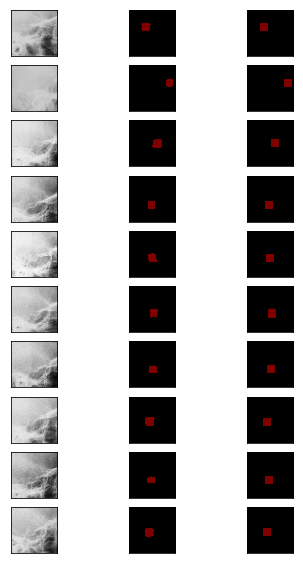

In [21]:
n = 10
imgs = []
acc1 = 0
acc2 = 0
for i in range(n):
    x = test_images[i]
    result = predict(x)
    f1,f2 = evaluate_acc(result,test_labels[i])
    if f1:
        acc1 += 1
    if f2:
        acc2 += 1

# print(acc1/n,"  ", acc2/n)
#     print(type(np.where(result.asnumpy()>0)[0]))
#     print(np.where(test_labels[i].asnumpy()>0))
    pred = label2image(predict(x))
    imgs += [x, pred, label2image(test_labels[i])]
# 
utils.show_images(imgs, nrows=n, ncols=3, figsize=(6,10))